In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [85]:
# Load data
prices = pd.read_csv("../../data/raw/prices.csv", parse_dates=["date"])
fundamentals = pd.read_csv("../../data/raw/fundamentals.csv")
securities = pd.read_csv("../../data/raw/securities.csv")

In [86]:
# Clean column names
fundamentals = fundamentals.drop(columns=["Unnamed: 0"])
fundamentals.rename(columns={"Ticker Symbol": "symbol"}, inplace=True)
securities.rename(columns={"Ticker symbol": "symbol"}, inplace=True)

# Merge datasets
data = prices.merge(securities, on="symbol").merge(fundamentals, on="symbol")

In [87]:
# get min and max dates
min_date = data['date'].min()
max_date = data['date'].max()
print(f"Data ranges from {min_date} to {max_date}")

Data ranges from 2010-01-04 to 2016-12-30 00:00:00


In [88]:
# list column names with missing values
missing_cols = data.columns[data.isnull().any()].tolist()
print("Columns with missing values:", missing_cols)

Columns with missing values: ['Date first added', 'Cash Ratio', 'Current Ratio', 'Quick Ratio', 'For Year', 'Earnings Per Share', 'Estimated Shares Outstanding']


In [89]:
# create a csv file with only the column names and save it in the experiments/jairo/ folder
data.columns.to_series().to_csv("../../experiments/jairo/column_names.csv", index=False, header=False)

In [90]:
# Feature engineering: 5-day return
data['return_5d'] = np.log(data['close'].shift(-5)) - np.log(data['open'])

# Lagged features
data['lag1'] = data['return_5d'].shift(1)
data['lag5'] = data['return_5d'].shift(5)

In [91]:
data = data.dropna(subset=['Date first added', 'Cash Ratio', 'Current Ratio', 'Quick Ratio', 'For Year', 'Earnings Per Share', 'Estimated Shares Outstanding', 'return_5d', 'lag1', 'lag5'])

Text(0.5, 1.0, 'Histogram of 5-Day Returns')

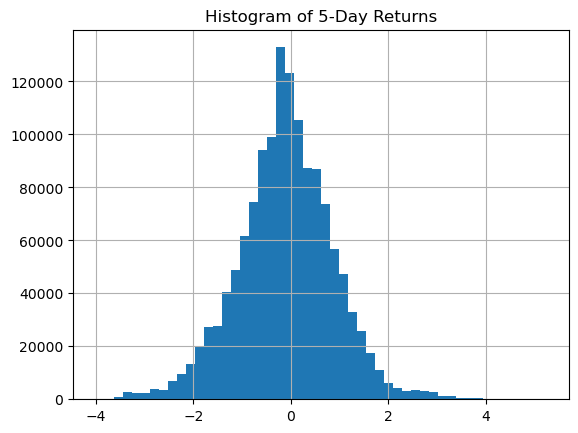

In [92]:
data['return_5d'].hist(bins=50)
plt.title('Histogram of 5-Day Returns')

In [93]:
# Train/test split by date
train = data[data['date'] < '2016-01-01']
test = data[data['date'] >= '2016-01-01']

X_train, y_train = train[['lag1','lag5']], train['return_5d']
X_test, y_test = test[['lag1','lag5']], test['return_5d']

# Model
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.36826381387556084


In [94]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_test, y_pred)
print("Test RMSE:", rmse)

Test RMSE: 0.6068474387154986
